# Two-Stage Global Fit

1.	Generate n number of replicas from whichever local fitting method we conclude is optimal for each kinematic set of which we have m, thus producing a nxm matrix for each Compton Form Factor.
2.	Define and compile a neural network, or other model form, with some set of as yet undetermined hyperparameters.
3.	Train n copies of that model on each row of that matrix, meaning each model sees m data points.  Repeat this for each Compton Form Factor.
4.	To interpolate a value of F for a novel kinematic set, feed that kinematic set into each model, producing n predictions of each CFF.  The mean of that n-sized vector would be the point estimate of our CFF, and the standard deviation would be our error.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

import utilities as uts

In [3]:
from BHDVCStf import BHDVCS #modified bhdvcs file

## Setup

In [4]:
numSets = 15
numReplicas = 500

bhdvcs = BHDVCS()

df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

localFits = np.fromfile('replicas500.txt')
localFits = localFits.reshape(numSets, numReplicas, 3)

## Define model

In [5]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="elu")(kinematics)
x = tf.keras.layers.Dense(20, activation="elu")(kinematics)
outputs = tf.keras.layers.Dense(3)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

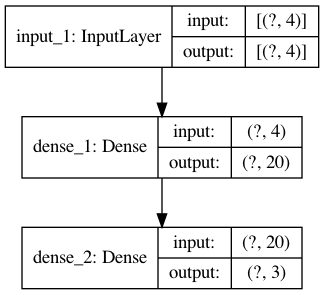

In [6]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [16]:
X = data.Kinematics.loc[np.array(range(numSets))*36, :].reset_index(drop=True)

y = np.array(data.CFFs.loc[np.array(range(numSets))*36, :].reset_index(drop=True))

In [33]:
rescaler = MinMaxScaler()

rescaler = rescaler.fit(X)
X_rescaled = rescaler.transform(X)

In [12]:
globalModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())
orig_weights = globalModel.get_weights()

# Produce results

In [56]:
def produceResults(model, X, localFits, orig_weights, numSets, numReplicas, epochs=150):
    '''
    Essentially LOO cross-val with y-values being generated from seperate local fit
    
    globalModel: a tensorflow neural network model
    X: standardized kinematic variables
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    numReplicas: the number of replicas
    
    returns: np array of cff predictions of shape (numSets, numReplicas, numCFFs)
    '''
    by_set = []
    for i in tqdm(range(numSets)):
        valid_x = X[[i], :]
        train_x = np.delete(X, i, axis=0)
        
        by_rep = []
        for rep in range(numReplicas):
            train_y = np.delete(localFits[:, rep, :], i, axis=0)
            
            model.set_weights(orig_weights)
            model.fit(train_x, train_y, epochs=epochs, verbose=0)
            by_rep.append(list(model.predict(valid_x)[0]))
        
        by_set.append(by_rep)

    return np.array(by_set)

In [57]:
results = produceResults(globalModel, X_rescaled, localFits, orig_weights, numSets, numReplicas)

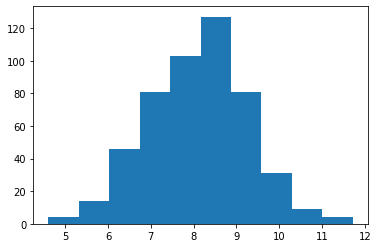

In [70]:
plt.hist(results[9, :, 0])
plt.show()

In [54]:
np.median(np.array(test)[:, 0])

12.763329

In [55]:
np.mean(np.array(test)[:, 0])

12.953586

# ReH

In [89]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  6.72550837761693
RMSE:  0.814350751421635
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.8960221013272468


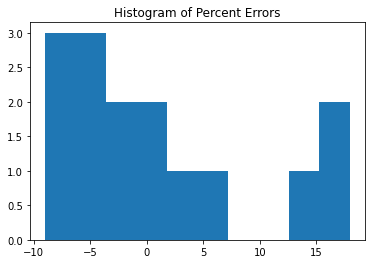

In [90]:
uts.evaluate(y_yhat)

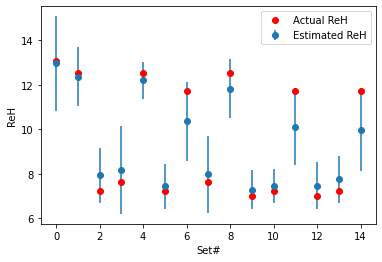

In [91]:
uts.plotError(y_yhat, err, "ReH")

# ReE

Mean percent error:  7.594378050421771
RMSE:  4.635241831997727
RMSE w yhat=mean:  2.525480507907797
R-squared:  -2.368656688422497


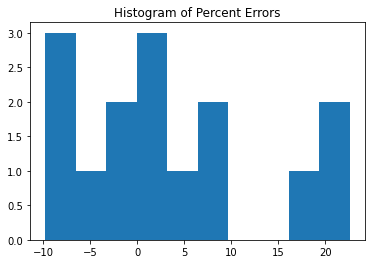

In [92]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)
uts.evaluate(y_yhat)

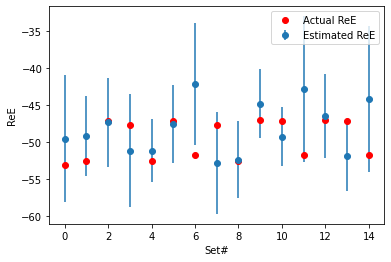

In [93]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  4.985715046696334
RMSE:  0.33766738584157796
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.9420782743492708


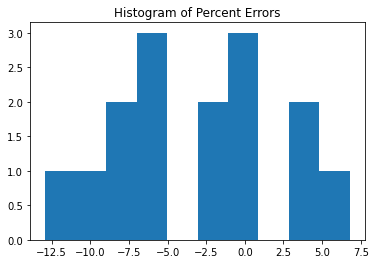

In [94]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

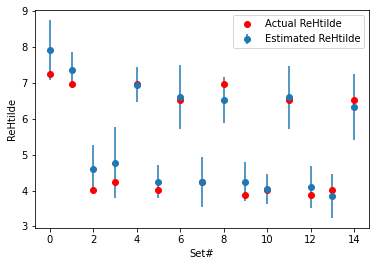

In [95]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  10.550985329810617
RMSE:  0.002703290408952403
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.970931855355441


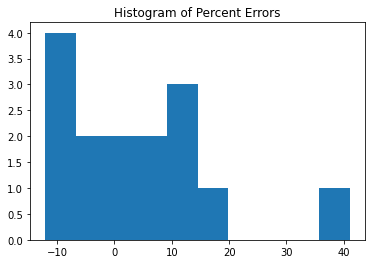

In [96]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

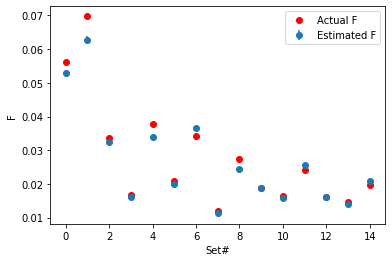

In [84]:
uts.plotError(y_yhat, err, "F")